## Import modules

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import sys
import dotenv
from datetime import datetime, timedelta, timezone
import os
from sklearn.ensemble import GradientBoostingRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Loading .env
dotenv.load_dotenv()

# Load sns styling
sns.set_theme(style="darkgrid")

## Initialize MT5

In [52]:
def shutdown_mt5() -> None:
    """Gracefully shut down MT5 connection."""
    mt5.shutdown()
    print("MT5 connection closed")

# Read environment variables
login = os.getenv("MT5_LOGIN")
password = os.getenv("MT5_PASSWORD")
server = os.getenv("MT5_SERVER")
timeframe = os.getenv("MT5_TIMEFRAME")
pair = os.getenv("MT5_PAIR", "XAUUSD")

if not all([login, password, server, timeframe]):
    print("Missing environment variables.")
    sys.exit(1)

# Cast login to int if present
login = int(login) if login else None

# Initialize MT5 terminal
if not mt5.initialize():
    print("MT5 initialize() failed")
    print("Error code:", mt5.last_error())
    sys.exit(1)

# Optional login (required if multiple terminals/accounts exist)
if login and password and server:
    authorized = mt5.login(
        login=login,
        password=password,
        server=server
    )
    if not authorized:
        print("MT5 login failed")
        print("Error code:", mt5.last_error())
        mt5.shutdown()
        sys.exit(1)

terminal_info = mt5.terminal_info()
account_info = mt5.account_info()

if terminal_info is None or account_info is None:
    print("Failed to retrieve terminal/account information")
    mt5.shutdown()
    sys.exit(1)

print("MT5 initialized successfully")

MT5 initialized successfully


## Retrieve data

In [53]:
# Map timeframe
TIMEFRAME_MAP = {
    "1HR": mt5.TIMEFRAME_H1,
    "30MIN": mt5.TIMEFRAME_M30
}

timeframe_mt5 = TIMEFRAME_MAP[timeframe]

# --- OHLC: full 1 year ---
utc_to = datetime.now(timezone.utc)
utc_from = utc_to - timedelta(days=365)

rates = mt5.copy_rates_range(
    pair,
    timeframe_mt5,
    utc_from,
    utc_to
)

df = pd.DataFrame(rates)
df["time"] = pd.to_datetime(df["time"], unit="s", utc=True)

# --- Minor feature engineering ---
df["typical_price"] = (df["high"] + df["low"] + df["close"]) / 3
df["price_range"] = df["high"] - df["low"]
df["body"] = abs(df["close"] - df["open"])
df["upper_wick"] = df["high"] - df[["open", "close"]].max(axis=1)
df["lower_wick"] = df[["open", "close"]].min(axis=1) - df["low"]
df["is_bullish"] = (df["close"] > df["open"]).astype(int)
df["is_bearish"] = (df["close"] < df["open"]).astype(int)

df.to_csv("./data/ONE_YEAR_DATA.csv")

## Validative Feature engineering

In [54]:
df["time"] = pd.to_datetime(df["time"])

# --- Calculate perpendicular tangent features ---
# Price momentum (first derivative approximation)
df["price_momentum"] = df["close"].diff()

# Price acceleration (second derivative approximation)
df["price_acceleration"] = df["price_momentum"].diff()

# Rolling statistics for context
df["momentum_5"] = df["close"].diff(5)
df["momentum_10"] = df["close"].diff(10)
df["volatility_10"] = df["close"].rolling(10).std()
df["volume_momentum"] = df["tick_volume"].diff()

# --- Create training labels (future price movement) ---
# Looking ahead to see what actually happened
lookahead = 5  # periods ahead
df["future_return"] = (df["close"].shift(-lookahead) - df["close"]) / df["close"]

# Remove NaN rows from feature calculation
df = df.dropna()

# --- Prepare ML features ---
feature_cols = [
    "price_momentum", "price_acceleration", "momentum_5", "momentum_10",
    "volatility_10", "volume_momentum", "price_range", "body",
    "upper_wick", "lower_wick", "is_bullish", "is_bearish"
]

X = df[feature_cols].values
y = df["future_return"].values

# --- Train ML model ---
# Use 80% for training, 20% for prediction
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_scaled = scaler.transform(X)

# Train gradient boosting model
model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
model.fit(X_train_scaled, y_train)

# --- Generate risk factor predictions ---
raw_predictions = model.predict(X_scaled)

# Normalize to -1 to 1 range
# Negative values (buy signal), positive values (sell signal)
percentile_98 = np.percentile(np.abs(raw_predictions), 98)
df["risk_factor"] = np.clip(raw_predictions / percentile_98, -1, 1)

df.head()

,time,open,high,low,close,tick_volume,spread,real_volume,typical_price,price_range,...,is_bullish,is_bearish,price_momentum,price_acceleration,momentum_5,momentum_10,volatility_10,volume_momentum,future_return,risk_factor
10,2025-01-27 11:00:00+00:00,2756.65,2765.00,2755.76,2763.33,4732,7,0,2761.363333,9.24,...,1,0,6.10,-1.63,5.21,-3.94,5.829033,1.844674e+19,-0.004538,-0.027728
11,2025-01-27 12:00:00+00:00,2763.16,2771.04,2762.86,2768.17,4933,5,0,2767.356667,8.18,...,1,0,4.84,-1.26,14.90,-1.51,5.520866,2.010000e+02,-0.009501,0.066939
12,2025-01-27 13:00:00+00:00,2767.88,2771.88,2764.94,2771.16,4867,8,0,2769.326667,6.94,...,1,0,2.99,-1.85,16.64,8.26,6.746480,1.844674e+19,-0.013258,0.071343
13,2025-01-27 14:00:00+00:00,2771.35,2771.52,2760.44,2761.22,4673,5,0,2764.393333,11.08,...,0,1,-9.94,-12.93,11.72,5.08,6.677015,1.844674e+19,-0.010010,-0.025794
14,2025-01-27 15:00:00+00:00,2761.05,2762.48,2752.28,2757.41,5474,6,0,2757.390000,10.20,...,0,1,-3.81,6.13,0.18,-3.67,6.697230,8.010000e+02,-0.007395,0.005243


## Display calculation

<Figure size 1600x1000 with 0 Axes>

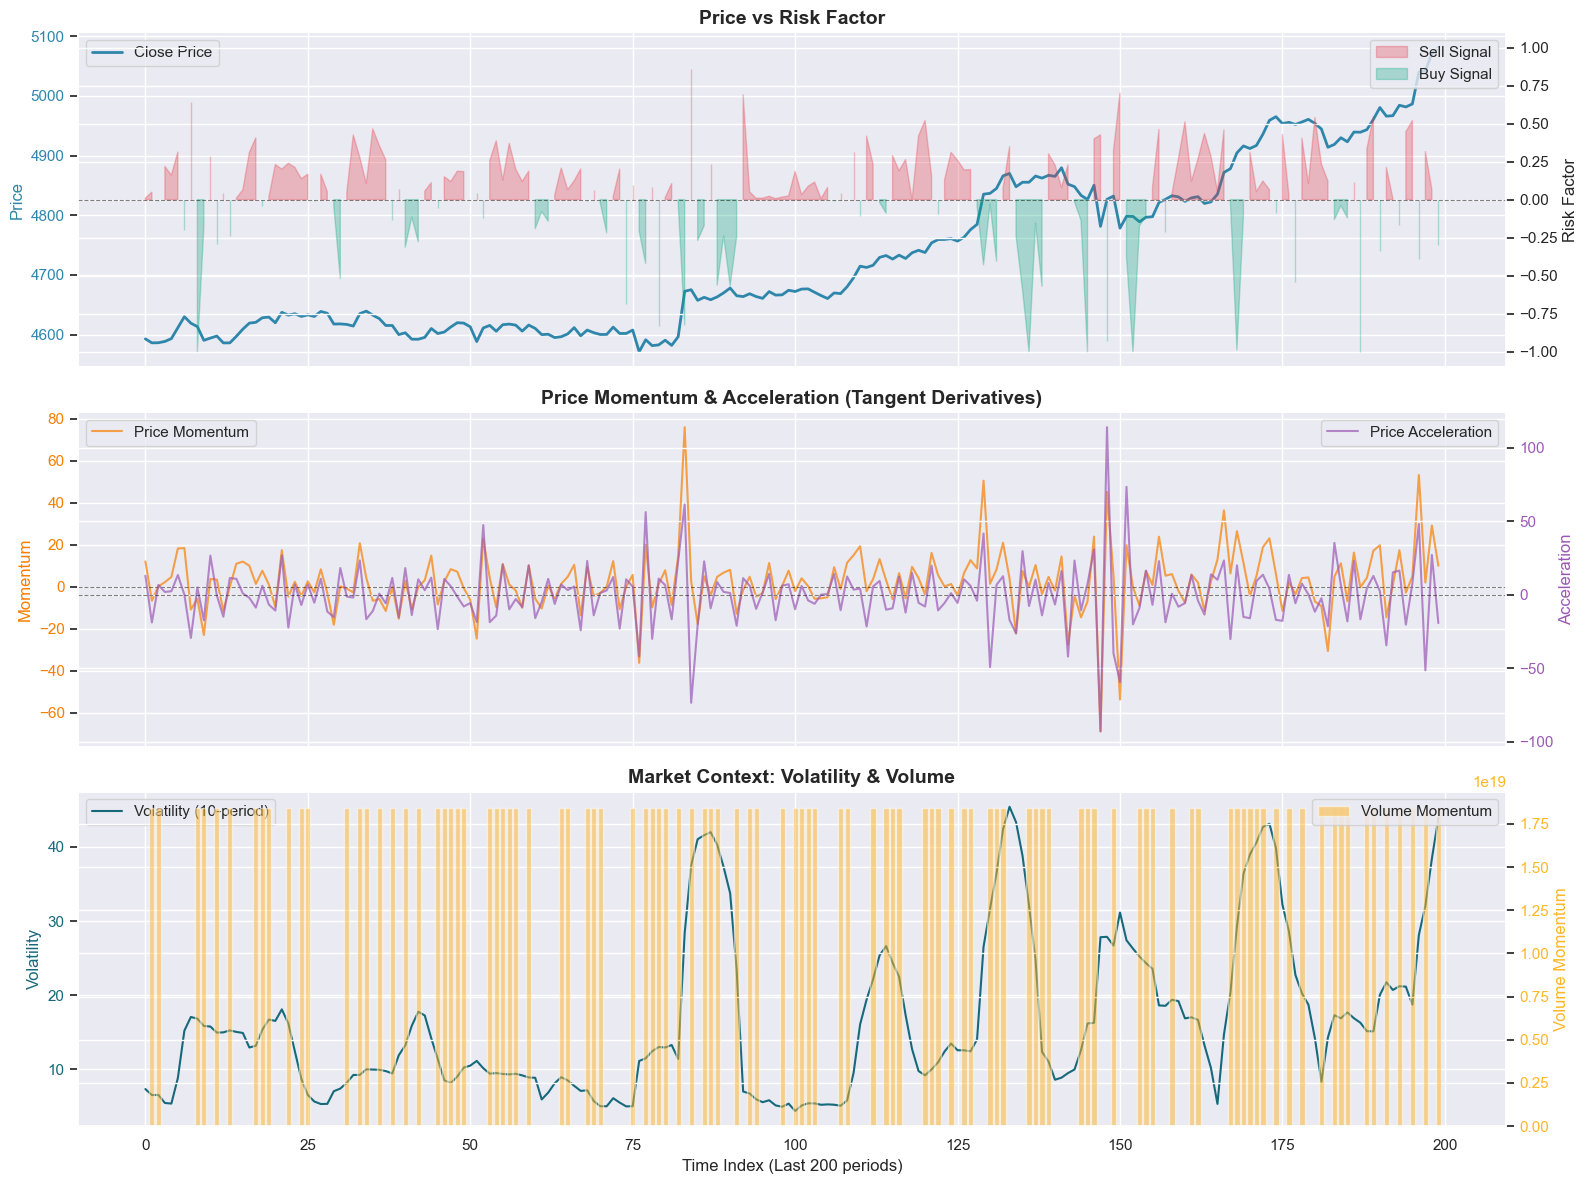


Risk Factor Statistics:
  Mean: 0.0730
  Std:  0.2516
  Min:  -1.0000
  Max:  1.0000

Signal Distribution:
  Buy signals (< 0):  1407 (24.0%)
  Sell signals (> 0): 4465 (76.0%)


In [55]:
# Set style
sns.set_style("darkgrid")
plt.figure(figsize=(16, 10))

# Use only the last 200 data points to avoid overcrowding
df_plot = df.tail(200).copy()
df_plot = df_plot.reset_index(drop=True)

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

# Plot 1: Price and Risk Factor
ax1 = axes[0]
ax1_twin = ax1.twinx()

# Price line
ax1.plot(df_plot.index, df_plot["close"], color="#2E86AB", linewidth=2, label="Close Price")
ax1.set_ylabel("Price", fontsize=12, color="#2E86AB")
ax1.tick_params(axis='y', labelcolor="#2E86AB")

# Risk factor as colored area
ax1_twin.fill_between(df_plot.index, 0, df_plot["risk_factor"], 
                       where=(df_plot["risk_factor"] >= 0), 
                       color="#E63946", alpha=0.3, label="Sell Signal")
ax1_twin.fill_between(df_plot.index, 0, df_plot["risk_factor"], 
                       where=(df_plot["risk_factor"] < 0), 
                       color="#06A77D", alpha=0.3, label="Buy Signal")
ax1_twin.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax1_twin.set_ylabel("Risk Factor", fontsize=12)
ax1_twin.set_ylim(-1.1, 1.1)

ax1.set_title("Price vs Risk Factor", fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')

# Plot 2: Price Momentum and Acceleration
ax2 = axes[1]
ax2_twin = ax2.twinx()

ax2.plot(df_plot.index, df_plot["price_momentum"], color="#F77F00", linewidth=1.5, label="Price Momentum", alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax2.set_ylabel("Momentum", fontsize=12, color="#F77F00")
ax2.tick_params(axis='y', labelcolor="#F77F00")

ax2_twin.plot(df_plot.index, df_plot["price_acceleration"], color="#9B59B6", linewidth=1.5, label="Price Acceleration", alpha=0.7)
ax2_twin.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax2_twin.set_ylabel("Acceleration", fontsize=12, color="#9B59B6")
ax2_twin.tick_params(axis='y', labelcolor="#9B59B6")

ax2.set_title("Price Momentum & Acceleration (Tangent Derivatives)", fontsize=14, fontweight='bold')
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')

# Plot 3: Volatility and Volume Momentum
ax3 = axes[2]
ax3_twin = ax3.twinx()

ax3.plot(df_plot.index, df_plot["volatility_10"], color="#16697A", linewidth=1.5, label="Volatility (10-period)")
ax3.set_ylabel("Volatility", fontsize=12, color="#16697A")
ax3.tick_params(axis='y', labelcolor="#16697A")

ax3_twin.bar(df_plot.index, df_plot["volume_momentum"], color="#FFB627", alpha=0.5, label="Volume Momentum", width=0.8)
ax3_twin.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax3_twin.set_ylabel("Volume Momentum", fontsize=12, color="#FFB627")
ax3_twin.tick_params(axis='y', labelcolor="#FFB627")

ax3.set_title("Market Context: Volatility & Volume", fontsize=14, fontweight='bold')
ax3.set_xlabel("Time Index (Last 200 periods)", fontsize=12)
ax3.legend(loc='upper left')
ax3_twin.legend(loc='upper right')

plt.tight_layout()
plt.savefig("./data/risk_factor_analysis.png", dpi=300, bbox_inches='tight')
plt.show()



print(f"\nRisk Factor Statistics:")
print(f"  Mean: {df['risk_factor'].mean():.4f}")
print(f"  Std:  {df['risk_factor'].std():.4f}")
print(f"  Min:  {df['risk_factor'].min():.4f}")
print(f"  Max:  {df['risk_factor'].max():.4f}")
print(f"\nSignal Distribution:")
print(f"  Buy signals (< 0):  {(df['risk_factor'] < 0).sum()} ({(df['risk_factor'] < 0).sum()/len(df)*100:.1f}%)")
print(f"  Sell signals (> 0): {(df['risk_factor'] > 0).sum()} ({(df['risk_factor'] > 0).sum()/len(df)*100:.1f}%)")

## Setup Deep Learning pipeline

Preparing data with improved features...
Training samples: 3993
Validation samples: 855
Test samples: 857
Sequence shape: (3993, 30, 20)
Number of features: 20

Using device: cuda

Training Improved CNN-LSTM with Multi-Head Attention model...


c:\Users\Ssali Benjamin\AppData\Local\Python\pythoncore-3.11-64\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/100], Train Loss: 0.000037, Val Loss: 0.000274
Epoch [20/100], Train Loss: 0.000023, Val Loss: 0.000107
Early stopping at epoch 29

Evaluating on test set...

Test Set Performance:
  MSE:  0.000025
  RMSE: 0.005017
  MAE:  0.003848
  Directional Accuracy: 50.64%
  Strong Signal Directional Accuracy: 61.46% (96 signals)

✓ Model saved to ./data/best_model_improved.pth
✓ Performance plots saved to ./data/model_performance.png
✓ Training complete!


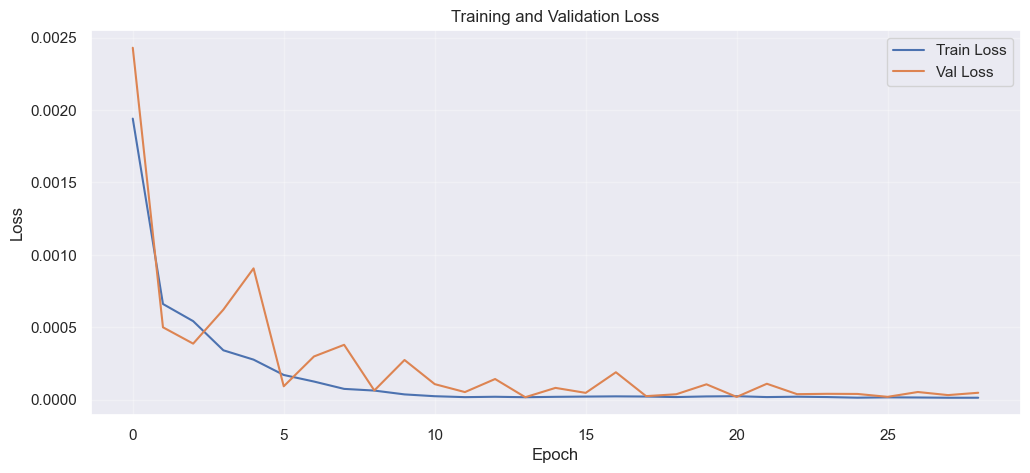

In [59]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# --- Enhanced Data Preparation ---
print("Preparing data with improved features...")

# Define feature columns (including risk_factor)
feature_cols = [
    "price_momentum", "price_acceleration", "momentum_5", "momentum_10",
    "volatility_10", "volume_momentum", "price_range", "body",
    "upper_wick", "lower_wick", "is_bullish", "is_bearish",
    "risk_factor"
]

# Add more technical features
df["ema_5"] = df["close"].ewm(span=5).mean()
df["ema_20"] = df["close"].ewm(span=20).mean()
df["ema_cross"] = (df["ema_5"] - df["ema_20"]) / df["close"]
df["volume_ratio"] = df["tick_volume"] / df["tick_volume"].rolling(20).mean()
df["price_position"] = (df["close"] - df["close"].rolling(20).min()) / (df["close"].rolling(20).max() - df["close"].rolling(20).min())

# Add lagged returns
for lag in [1, 2, 3, 5]:
    df[f"return_lag_{lag}"] = df["close"].pct_change(lag)

enhanced_features = feature_cols + ["ema_cross", "volume_ratio", "price_position", 
                                     "return_lag_1", "return_lag_2", "return_lag_3", "return_lag_5"]

# Remove rows with NaN
df_clean = df[enhanced_features + ["future_return"]].dropna()

# Remove extreme outliers (helps model focus on normal market conditions)
threshold = df_clean["future_return"].quantile([0.01, 0.99])
df_clean = df_clean[(df_clean["future_return"] >= threshold[0.01]) & 
                     (df_clean["future_return"] <= threshold[0.99])]

# Create sequences for LSTM (lookback window)
lookback = 30  # Increased from 20 for more context

def create_sequences(data, target, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i])
        y.append(target[i])
    return np.array(X), np.array(y)

# Use RobustScaler (better for outliers than StandardScaler)
scaler = RobustScaler()
features_scaled = scaler.fit_transform(df_clean[enhanced_features].values)
target = df_clean["future_return"].values

# Create sequences
X_seq, y_seq = create_sequences(features_scaled, target, lookback)

# Train/Val/Test split (70/15/15)
train_size = int(len(X_seq) * 0.7)
val_size = int(len(X_seq) * 0.15)

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_val = X_seq[train_size:train_size+val_size]
y_val = y_seq[train_size:train_size+val_size]

X_test = X_seq[train_size+val_size:]
y_test = y_seq[train_size+val_size:]

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")
print(f"Sequence shape: {X_train.shape}")
print(f"Number of features: {X_train.shape[2]}")

# --- PyTorch Dataset with Data Augmentation ---
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        self.augment = augment
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        
        # Add noise augmentation during training
        if self.augment and torch.rand(1) > 0.5:
            noise = torch.randn_like(x) * 0.01
            x = x + noise
        
        return x, y

train_dataset = TimeSeriesDataset(X_train, y_train, augment=True)
val_dataset = TimeSeriesDataset(X_val, y_val, augment=False)
test_dataset = TimeSeriesDataset(X_test, y_test, augment=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Shuffle for better training
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# --- Improved PyTorch Model: CNN-LSTM with Multi-Head Attention ---
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads=4):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.hidden_size = hidden_size
        self.head_dim = hidden_size // num_heads
        
        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, hidden_size)
    
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        Q = self.query(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attention_weights = torch.softmax(scores, dim=-1)
        
        context = torch.matmul(attention_weights, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.hidden_size)
        
        output = self.fc_out(context)
        return output.mean(dim=1)  # Global average pooling

class ImprovedCNN_LSTM_Attention(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=3, dropout=0.3, num_heads=4):
        super(ImprovedCNN_LSTM_Attention, self).__init__()
        
        # Deeper CNN for pattern extraction
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.dropout_cnn = nn.Dropout(dropout)
        
        # Bidirectional LSTM for sequential learning
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        # Multi-head attention mechanism
        self.attention = MultiHeadAttention(hidden_size * 2, num_heads=num_heads)
        
        # Residual connection
        self.residual = nn.Linear(input_size, hidden_size * 2)
        
        # Fully connected layers with skip connection
        self.fc1 = nn.Linear(hidden_size * 2, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn_fc2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout_fc = nn.Dropout(dropout)
    
    def forward(self, x):
        # x shape: (batch, seq_len, features)
        residual_input = x.mean(dim=1)  # Average over sequence for residual
        
        # Transpose for CNN (batch, features, seq_len)
        x = x.transpose(1, 2)
        
        # CNN layers with batch norm
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.dropout_cnn(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout_cnn(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.dropout_cnn(x)
        
        # Transpose back for LSTM (batch, seq_len, features)
        x = x.transpose(1, 2)
        
        # Bidirectional LSTM layer
        lstm_out, _ = self.lstm(x)
        
        # Multi-head attention layer
        context_vector = self.attention(lstm_out)
        
        # Add residual connection
        residual = self.residual(residual_input)
        context_vector = context_vector + residual
        
        # Fully connected layers with batch norm
        x = self.relu(self.bn_fc1(self.fc1(context_vector)))
        x = self.dropout_fc(x)
        x = self.relu(self.bn_fc2(self.fc2(x)))
        x = self.dropout_fc(x)
        output = self.fc3(x)
        
        return output.squeeze()

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

model = ImprovedCNN_LSTM_Attention(
    input_size=len(enhanced_features),
    hidden_size=128,
    num_layers=3,
    dropout=0.3,
    num_heads=4
).to(device)

# Use Huber Loss (more robust to outliers than MSE)
criterion = nn.HuberLoss(delta=0.01)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7, verbose=False)

# --- Training Loop ---
print("\nTraining Improved CNN-LSTM with Multi-Head Attention model...")
num_epochs = 100
best_val_loss = float('inf')
patience_counter = 0
early_stopping_patience = 15

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Learning rate scheduling
    scheduler.step(avg_val_loss)
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), './data/best_model_improved.pth')
    else:
        patience_counter += 1
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    
    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(torch.load('./data/best_model_improved.pth', weights_only=True))

# --- Evaluation ---
print("\nEvaluating on test set...")
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(batch_y.numpy())

predictions = np.array(predictions)
actuals = np.array(actuals)

# Calculate metrics
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mse)

print(f"\nTest Set Performance:")
print(f"  MSE:  {mse:.6f}")
print(f"  RMSE: {rmse:.6f}")
print(f"  MAE:  {mae:.6f}")

# Directional accuracy
direction_correct = np.sum((predictions > 0) == (actuals > 0))
direction_accuracy = direction_correct / len(predictions) * 100
print(f"  Directional Accuracy: {direction_accuracy:.2f}%")

# Profitable trade accuracy (stronger signals)
strong_threshold = 0.001
strong_predictions = np.abs(predictions) > strong_threshold
if strong_predictions.sum() > 0:
    strong_direction_correct = np.sum((predictions[strong_predictions] > 0) == (actuals[strong_predictions] > 0))
    strong_direction_accuracy = strong_direction_correct / strong_predictions.sum() * 100
    print(f"  Strong Signal Directional Accuracy: {strong_direction_accuracy:.2f}% ({strong_predictions.sum()} signals)")

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 1, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)


print(f"\n✓ Model saved to ./data/best_model_improved.pth")
print(f"✓ Performance plots saved to ./data/model_performance.png")
print(f"✓ Training complete!")